In [1]:
!pip install -q transformers datasets evaluate accelerate gluonts ujson

In [2]:
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW

In [4]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Specify train/test split fraction
train_fraction = 0.9  # 80% for training, 20% for testing

# Split the original training set into new train/test sets
split_dataset = tc_dataset["train"].train_test_split(train_size=train_fraction, seed=42)

In [6]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 239
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 27
    })
})

In [7]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(m-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )

    return tc

In [8]:
from datasets import Dataset
m1 = find_pad_max(split_dataset["train"])
m2 = find_pad_max(split_dataset["test"])
m = max(m1,m2)
print(m)

61


In [9]:
train_data = pad_data(split_dataset["train"], m=m, split="train")
test_data = pad_data(split_dataset["test"], m=m, split="test")

In [10]:
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

In [11]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 239
})

In [12]:
test_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 27
})

In [13]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [14]:
train_example = train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

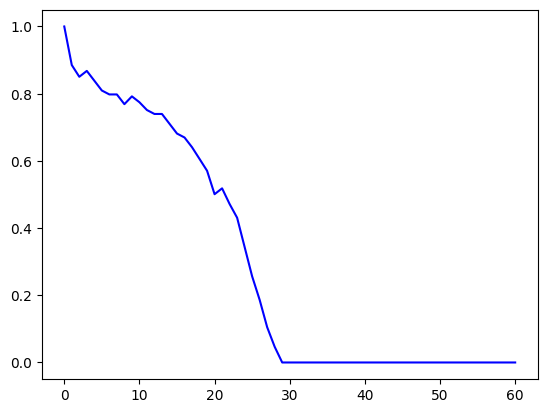

In [15]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(
          # train_example["feat_dynamic_real"][-num_of_samples:],
          train_example["target"][-num_of_samples:],
          color="blue")

plt.show()

In [16]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [17]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [18]:
num_of_variates = len(test_dataset) # group according to the smaller test dataset size

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates
    # max_target_dim=num_of_variates,
    # num_test_dates=len(test_dataset),
    # num_test_dates=None, # len(test_dataset),
    # num_of_variates=num  # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [19]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (27, 99)


In [20]:
multi_variate_test_example = multi_variate_test_dataset[0]
print(
    f"multi_variate_test_example['target'].shape = {multi_variate_test_example['target'].shape}"
)

multi_variate_test_example['target'].shape = (27, 95)


In [21]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x7e4e7785a520>, <function week_of_year at 0x7e4e7785a8e0>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [22]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [23]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [24]:
model = None

In [25]:
from transformers import InformerForPrediction

In [26]:
try:
    model = InformerForPrediction.from_pretrained("shaddie/rocketpill_thrustcurve_informer_model")
    print(f"successfully loaded model from hugging face with Config {model.config}")
except:
    print(f"An exception occurred when loading model from HF; initializing new model...")
    config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
    )

    model = InformerForPrediction(config)
    print(f"New model initialized with config {model.config}")

An exception occurred when loading model from HF; initializing new model...
New model initialized with config InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 16,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "feature_size": 111,
  "init_std": 0.02,
  "input_size": 27,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    168
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 3,
  "prediction

In [27]:
model.config.distribution_output

'student_t'

In [28]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [29]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [30]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [31]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [32]:
config = model.config

In [33]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)


In [34]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 27]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 27]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 27]) torch.FloatTensor


In [35]:
batch = next(iter(test_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


In [36]:
from tqdm import tqdm
epochs = 300
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
    for idx, batch in enumerate(progress_bar):
        # print(f'idx: {idx}')
        # for k, v in batch.items():
        #     print(k, v.shape, v.type())
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 200 == 0:
            print(f'Epoch {epoch} & idx {idx} with loss: {loss.item()}')

Epoch 1/300 : 1it [00:04,  4.11s/it, loss=-70.6]

Epoch 0 & idx 0 with loss: -70.58369445800781


Epoch 1/300 : 100it [01:02,  1.59it/s, loss=-103]
Epoch 2/300 : 1it [00:00,  4.81it/s, loss=-117]

Epoch 1 & idx 0 with loss: -116.98674011230469


Epoch 2/300 : 100it [00:22,  4.43it/s, loss=-129]
Epoch 3/300 : 2it [00:00,  8.06it/s, loss=-129]

Epoch 2 & idx 0 with loss: -127.97795104980469


Epoch 3/300 : 100it [00:13,  7.40it/s, loss=-139]
Epoch 4/300 : 2it [00:00,  8.28it/s, loss=-149]

Epoch 3 & idx 0 with loss: -145.09506225585938


Epoch 4/300 : 100it [00:13,  7.34it/s, loss=-146]
Epoch 5/300 : 2it [00:00,  6.86it/s, loss=-149]

Epoch 4 & idx 0 with loss: -147.9849853515625


Epoch 5/300 : 100it [00:13,  7.53it/s, loss=-153]
Epoch 6/300 : 2it [00:00,  7.14it/s, loss=-155]

Epoch 5 & idx 0 with loss: -163.15478515625


Epoch 6/300 : 100it [00:13,  7.56it/s, loss=-155]
Epoch 7/300 : 2it [00:00,  8.39it/s, loss=-168]

Epoch 6 & idx 0 with loss: -168.4783172607422


Epoch 7/300 : 100it [00:13,  7.40it/s, loss=-158]
Epoch 8/300 : 2it [00:00,  8.00it/s, loss=-167]

Epoch 7 & idx 0 with loss: -173.69935607910156


Epoch 8/300 : 100it [00:13,  7.30it/s, loss=-160]
Epoch 9/300 : 1it [00:00,  5.07it/s, loss=-173]

Epoch 8 & idx 0 with loss: -176.97283935546875


Epoch 9/300 : 100it [00:13,  7.19it/s, loss=-160]
Epoch 10/300 : 2it [00:00,  5.28it/s, loss=-165]

Epoch 9 & idx 0 with loss: -173.28652954101562


Epoch 10/300 : 100it [00:21,  4.69it/s, loss=-164]
Epoch 11/300 : 2it [00:00,  8.04it/s, loss=-164]

Epoch 10 & idx 0 with loss: -168.84068298339844


Epoch 11/300 : 100it [00:13,  7.39it/s, loss=-164]
Epoch 12/300 : 2it [00:00,  7.85it/s, loss=-157]

Epoch 11 & idx 0 with loss: -156.88262939453125


Epoch 12/300 : 100it [00:13,  7.51it/s, loss=-166]
Epoch 13/300 : 2it [00:00,  8.23it/s, loss=-168]

Epoch 12 & idx 0 with loss: -179.80960083007812


Epoch 13/300 : 100it [00:13,  7.24it/s, loss=-165]
Epoch 14/300 : 2it [00:00,  6.15it/s, loss=-164]

Epoch 13 & idx 0 with loss: -164.31396484375


Epoch 14/300 : 100it [00:13,  7.16it/s, loss=-169]
Epoch 15/300 : 2it [00:00,  7.93it/s, loss=-173]

Epoch 14 & idx 0 with loss: -172.98988342285156


Epoch 15/300 : 100it [00:13,  7.41it/s, loss=-169]
Epoch 16/300 : 2it [00:00,  8.02it/s, loss=-164]

Epoch 15 & idx 0 with loss: -170.96044921875


Epoch 16/300 : 100it [00:13,  7.44it/s, loss=-171]
Epoch 17/300 : 2it [00:00,  7.35it/s, loss=-174]

Epoch 16 & idx 0 with loss: -179.68582153320312


Epoch 17/300 : 100it [00:13,  7.37it/s, loss=-171]
Epoch 18/300 : 2it [00:00,  8.42it/s, loss=-162]

Epoch 17 & idx 0 with loss: -163.76806640625


Epoch 18/300 : 100it [00:13,  7.56it/s, loss=-171]
Epoch 19/300 : 2it [00:00,  7.41it/s, loss=-168]

Epoch 18 & idx 0 with loss: -166.4527587890625


Epoch 19/300 : 100it [00:13,  7.58it/s, loss=-172]
Epoch 20/300 : 2it [00:00,  8.22it/s, loss=-178]

Epoch 19 & idx 0 with loss: -168.98519897460938


Epoch 20/300 : 100it [00:13,  7.53it/s, loss=-172]
Epoch 21/300 : 2it [00:00,  8.06it/s, loss=-171]

Epoch 20 & idx 0 with loss: -162.26608276367188


Epoch 21/300 : 100it [00:13,  7.45it/s, loss=-176]
Epoch 22/300 : 2it [00:00,  7.40it/s, loss=-173]

Epoch 21 & idx 0 with loss: -179.29412841796875


Epoch 22/300 : 100it [00:13,  7.39it/s, loss=-175]
Epoch 23/300 : 2it [00:00,  7.93it/s, loss=-172]

Epoch 22 & idx 0 with loss: -168.396728515625


Epoch 23/300 : 100it [00:13,  7.45it/s, loss=-174]
Epoch 24/300 : 2it [00:00,  7.37it/s, loss=-179]

Epoch 23 & idx 0 with loss: -173.22964477539062


Epoch 24/300 : 100it [00:13,  7.37it/s, loss=-176]
Epoch 25/300 : 2it [00:00,  7.34it/s, loss=-186]

Epoch 24 & idx 0 with loss: -181.47879028320312


Epoch 25/300 : 100it [00:13,  7.55it/s, loss=-178]
Epoch 26/300 : 2it [00:00,  6.05it/s, loss=-180]

Epoch 25 & idx 0 with loss: -180.67135620117188


Epoch 26/300 : 100it [00:13,  7.47it/s, loss=-178]
Epoch 27/300 : 2it [00:00,  5.59it/s, loss=-176]

Epoch 26 & idx 0 with loss: -179.77114868164062


Epoch 27/300 : 100it [00:13,  7.33it/s, loss=-178]
Epoch 28/300 : 2it [00:00,  8.19it/s, loss=-176]

Epoch 27 & idx 0 with loss: -161.8790740966797


Epoch 28/300 : 100it [00:13,  7.50it/s, loss=-180]
Epoch 29/300 : 2it [00:00,  8.34it/s, loss=-171]

Epoch 28 & idx 0 with loss: -176.09640502929688


Epoch 29/300 : 100it [00:13,  7.41it/s, loss=-180]
Epoch 30/300 : 2it [00:00,  8.06it/s, loss=-172]

Epoch 29 & idx 0 with loss: -174.40377807617188


Epoch 30/300 : 100it [00:13,  7.45it/s, loss=-180]
Epoch 31/300 : 2it [00:00,  6.98it/s, loss=-185]

Epoch 30 & idx 0 with loss: -180.28524780273438


Epoch 31/300 : 100it [00:13,  7.29it/s, loss=-180]
Epoch 32/300 : 2it [00:00,  8.00it/s, loss=-179]

Epoch 31 & idx 0 with loss: -175.02395629882812


Epoch 32/300 : 100it [00:13,  7.43it/s, loss=-180]
Epoch 33/300 : 2it [00:00,  8.39it/s, loss=-180]

Epoch 32 & idx 0 with loss: -192.87557983398438


Epoch 33/300 : 100it [00:13,  7.38it/s, loss=-183]
Epoch 34/300 : 2it [00:00,  7.86it/s, loss=-186]

Epoch 33 & idx 0 with loss: -181.30197143554688


Epoch 34/300 : 100it [00:13,  7.30it/s, loss=-182]
Epoch 35/300 : 2it [00:00,  7.95it/s, loss=-176]

Epoch 34 & idx 0 with loss: -190.28884887695312


Epoch 35/300 : 100it [00:13,  7.36it/s, loss=-183]
Epoch 36/300 : 2it [00:00,  7.78it/s, loss=-186]

Epoch 35 & idx 0 with loss: -182.43850708007812


Epoch 36/300 : 100it [00:13,  7.36it/s, loss=-182]
Epoch 37/300 : 2it [00:00,  8.36it/s, loss=-184]

Epoch 36 & idx 0 with loss: -180.2036590576172


Epoch 37/300 : 100it [00:13,  7.25it/s, loss=-184]
Epoch 38/300 : 2it [00:00,  6.08it/s, loss=-186]

Epoch 37 & idx 0 with loss: -173.17974853515625


Epoch 38/300 : 100it [00:13,  7.20it/s, loss=-186]
Epoch 39/300 : 2it [00:00,  6.70it/s, loss=-197]

Epoch 38 & idx 0 with loss: -191.17633056640625


Epoch 39/300 : 100it [00:13,  7.38it/s, loss=-186]
Epoch 40/300 : 2it [00:00,  7.99it/s, loss=-188]

Epoch 39 & idx 0 with loss: -186.50497436523438


Epoch 40/300 : 100it [00:13,  7.56it/s, loss=-184]
Epoch 41/300 : 2it [00:00,  7.52it/s, loss=-185]

Epoch 40 & idx 0 with loss: -185.969482421875


Epoch 41/300 : 100it [00:13,  7.43it/s, loss=-184]
Epoch 42/300 : 2it [00:00,  7.82it/s, loss=-180]

Epoch 41 & idx 0 with loss: -171.50527954101562


Epoch 42/300 : 100it [00:13,  7.42it/s, loss=-187]
Epoch 43/300 : 2it [00:00,  8.27it/s, loss=-166]

Epoch 42 & idx 0 with loss: -173.14315795898438


Epoch 43/300 : 100it [00:13,  7.60it/s, loss=-185]
Epoch 44/300 : 2it [00:00,  8.02it/s, loss=-189]

Epoch 43 & idx 0 with loss: -194.35415649414062


Epoch 44/300 : 100it [00:13,  7.45it/s, loss=-187]
Epoch 45/300 : 2it [00:00,  7.73it/s, loss=-175]

Epoch 44 & idx 0 with loss: -181.99632263183594


Epoch 45/300 : 100it [00:13,  7.43it/s, loss=-187]
Epoch 46/300 : 2it [00:00,  8.10it/s, loss=-188]

Epoch 45 & idx 0 with loss: -186.5103759765625


Epoch 46/300 : 100it [00:13,  7.22it/s, loss=-187]
Epoch 47/300 : 2it [00:00,  8.00it/s, loss=-187]

Epoch 46 & idx 0 with loss: -187.45516967773438


Epoch 47/300 : 100it [00:13,  7.41it/s, loss=-188]
Epoch 48/300 : 2it [00:00,  7.71it/s, loss=-191]

Epoch 47 & idx 0 with loss: -192.3115234375


Epoch 48/300 : 100it [00:13,  7.41it/s, loss=-187]
Epoch 49/300 : 2it [00:00,  7.30it/s, loss=-182]

Epoch 48 & idx 0 with loss: -179.60169982910156


Epoch 49/300 : 100it [00:13,  7.16it/s, loss=-190]
Epoch 50/300 : 2it [00:00,  6.01it/s, loss=-191]

Epoch 49 & idx 0 with loss: -187.43023681640625


Epoch 50/300 : 100it [00:13,  7.29it/s, loss=-187]
Epoch 51/300 : 2it [00:00,  8.33it/s, loss=-164]

Epoch 50 & idx 0 with loss: -162.52432250976562


Epoch 51/300 : 100it [00:13,  7.51it/s, loss=-188]
Epoch 52/300 : 2it [00:00,  7.20it/s, loss=-186]

Epoch 51 & idx 0 with loss: -185.70021057128906


Epoch 52/300 : 100it [00:13,  7.55it/s, loss=-189]
Epoch 53/300 : 2it [00:00,  8.37it/s, loss=-181]

Epoch 52 & idx 0 with loss: -180.02999877929688


Epoch 53/300 : 100it [00:13,  7.49it/s, loss=-188]
Epoch 54/300 : 2it [00:00,  7.73it/s, loss=-188]

Epoch 53 & idx 0 with loss: -185.05783081054688


Epoch 54/300 : 100it [00:13,  7.38it/s, loss=-190]
Epoch 55/300 : 2it [00:00,  7.28it/s, loss=-176]

Epoch 54 & idx 0 with loss: -193.59597778320312


Epoch 55/300 : 100it [00:13,  7.50it/s, loss=-189]
Epoch 56/300 : 2it [00:00,  8.07it/s, loss=-180]

Epoch 55 & idx 0 with loss: -165.11196899414062


Epoch 56/300 : 100it [00:13,  7.56it/s, loss=-189]
Epoch 57/300 : 2it [00:00,  8.14it/s, loss=-194]

Epoch 56 & idx 0 with loss: -193.03187561035156


Epoch 57/300 : 100it [00:13,  7.52it/s, loss=-190]
Epoch 58/300 : 2it [00:00,  6.56it/s, loss=-200]

Epoch 57 & idx 0 with loss: -200.10845947265625


Epoch 58/300 : 100it [00:13,  7.46it/s, loss=-189]
Epoch 59/300 : 2it [00:00,  8.12it/s, loss=-174]

Epoch 58 & idx 0 with loss: -173.01019287109375


Epoch 59/300 : 100it [00:14,  7.13it/s, loss=-193]
Epoch 60/300 : 2it [00:00,  8.02it/s, loss=-181]

Epoch 59 & idx 0 with loss: -192.4285888671875


Epoch 60/300 : 100it [00:13,  7.41it/s, loss=-191]
Epoch 61/300 : 2it [00:00,  8.26it/s, loss=-192]

Epoch 60 & idx 0 with loss: -191.58212280273438


Epoch 61/300 : 100it [00:14,  7.14it/s, loss=-191]
Epoch 62/300 : 2it [00:00,  5.60it/s, loss=-188]

Epoch 61 & idx 0 with loss: -192.36489868164062


Epoch 62/300 : 100it [00:14,  7.12it/s, loss=-191]
Epoch 63/300 : 2it [00:00,  7.30it/s, loss=-196]

Epoch 62 & idx 0 with loss: -196.0679168701172


Epoch 63/300 : 100it [00:13,  7.27it/s, loss=-191]
Epoch 64/300 : 2it [00:00,  7.74it/s, loss=-192]

Epoch 63 & idx 0 with loss: -193.14398193359375


Epoch 64/300 : 100it [00:13,  7.25it/s, loss=-193]
Epoch 65/300 : 2it [00:00,  7.38it/s, loss=-199]

Epoch 64 & idx 0 with loss: -200.5413818359375


Epoch 65/300 : 100it [00:13,  7.38it/s, loss=-192]
Epoch 66/300 : 2it [00:00,  7.56it/s, loss=-193]

Epoch 65 & idx 0 with loss: -177.65216064453125


Epoch 66/300 : 100it [00:13,  7.39it/s, loss=-193]
Epoch 67/300 : 2it [00:00,  7.42it/s, loss=-193]

Epoch 66 & idx 0 with loss: -199.000244140625


Epoch 67/300 : 100it [00:13,  7.35it/s, loss=-193]
Epoch 68/300 : 2it [00:00,  7.33it/s, loss=-192]

Epoch 67 & idx 0 with loss: -197.7890167236328


Epoch 68/300 : 100it [00:13,  7.29it/s, loss=-192]
Epoch 69/300 : 2it [00:00,  7.64it/s, loss=-192]

Epoch 68 & idx 0 with loss: -193.7299346923828


Epoch 69/300 : 100it [00:13,  7.39it/s, loss=-192]
Epoch 70/300 : 2it [00:00,  7.51it/s, loss=-187]

Epoch 69 & idx 0 with loss: -193.64285278320312


Epoch 70/300 : 100it [00:13,  7.20it/s, loss=-193]
Epoch 71/300 : 2it [00:00,  5.93it/s, loss=-186]

Epoch 70 & idx 0 with loss: -186.63143920898438


Epoch 71/300 : 100it [00:13,  7.32it/s, loss=-192]
Epoch 72/300 : 2it [00:00,  7.95it/s, loss=-192]

Epoch 71 & idx 0 with loss: -185.29159545898438


Epoch 72/300 : 100it [00:13,  7.42it/s, loss=-193]
Epoch 73/300 : 2it [00:00,  7.41it/s, loss=-190]

Epoch 72 & idx 0 with loss: -188.17898559570312


Epoch 73/300 : 100it [00:13,  7.36it/s, loss=-193]
Epoch 74/300 : 2it [00:00,  8.38it/s, loss=-196]

Epoch 73 & idx 0 with loss: -199.48544311523438


Epoch 74/300 : 100it [00:13,  7.47it/s, loss=-195]
Epoch 75/300 : 2it [00:00,  8.80it/s, loss=-186]

Epoch 74 & idx 0 with loss: -181.5758056640625


Epoch 75/300 : 100it [00:13,  7.59it/s, loss=-192]
Epoch 76/300 : 2it [00:00,  8.39it/s, loss=-198]

Epoch 75 & idx 0 with loss: -195.62789916992188


Epoch 76/300 : 100it [00:13,  7.42it/s, loss=-193]
Epoch 77/300 : 2it [00:00,  7.90it/s, loss=-194]

Epoch 76 & idx 0 with loss: -194.30331420898438


Epoch 77/300 : 100it [00:13,  7.36it/s, loss=-193]
Epoch 78/300 : 2it [00:00,  8.64it/s, loss=-187]

Epoch 77 & idx 0 with loss: -184.81817626953125


Epoch 78/300 : 100it [00:13,  7.55it/s, loss=-194]
Epoch 79/300 : 2it [00:00,  7.73it/s, loss=-196]

Epoch 78 & idx 0 with loss: -202.26953125


Epoch 79/300 : 100it [00:13,  7.52it/s, loss=-195]
Epoch 80/300 : 2it [00:00,  8.46it/s, loss=-189]

Epoch 79 & idx 0 with loss: -186.45150756835938


Epoch 80/300 : 100it [00:13,  7.45it/s, loss=-195]
Epoch 81/300 : 2it [00:00,  5.82it/s, loss=-199]

Epoch 80 & idx 0 with loss: -190.25416564941406


Epoch 81/300 : 100it [00:14,  7.08it/s, loss=-196]
Epoch 82/300 : 2it [00:00,  6.86it/s, loss=-190]

Epoch 81 & idx 0 with loss: -182.80758666992188


Epoch 82/300 : 100it [00:13,  7.46it/s, loss=-196]
Epoch 83/300 : 2it [00:00,  7.67it/s, loss=-189]

Epoch 82 & idx 0 with loss: -191.9654541015625


Epoch 83/300 : 100it [00:13,  7.39it/s, loss=-195]
Epoch 84/300 : 2it [00:00,  7.65it/s, loss=-181]

Epoch 83 & idx 0 with loss: -180.38934326171875


Epoch 84/300 : 100it [00:13,  7.42it/s, loss=-194]
Epoch 85/300 : 2it [00:00,  7.70it/s, loss=-187]

Epoch 84 & idx 0 with loss: -188.33087158203125


Epoch 85/300 : 100it [00:13,  7.37it/s, loss=-196]
Epoch 86/300 : 2it [00:00,  7.88it/s, loss=-198]

Epoch 85 & idx 0 with loss: -191.3905792236328


Epoch 86/300 : 100it [00:13,  7.34it/s, loss=-193]
Epoch 87/300 : 2it [00:00,  7.68it/s, loss=-184]

Epoch 86 & idx 0 with loss: -194.3765869140625


Epoch 87/300 : 100it [00:13,  7.49it/s, loss=-195]
Epoch 88/300 : 2it [00:00,  7.48it/s, loss=-194]

Epoch 87 & idx 0 with loss: -194.4942626953125


Epoch 88/300 : 100it [00:13,  7.38it/s, loss=-197]
Epoch 89/300 : 2it [00:00,  7.90it/s, loss=-194]

Epoch 88 & idx 0 with loss: -200.64035034179688


Epoch 89/300 : 100it [00:13,  7.37it/s, loss=-197]
Epoch 90/300 : 2it [00:00,  7.44it/s, loss=-197]

Epoch 89 & idx 0 with loss: -199.84913635253906


Epoch 90/300 : 100it [00:13,  7.22it/s, loss=-197]
Epoch 91/300 : 2it [00:00,  5.57it/s, loss=-195]

Epoch 90 & idx 0 with loss: -192.89559936523438


Epoch 91/300 : 100it [00:13,  7.37it/s, loss=-197]
Epoch 92/300 : 2it [00:00,  8.14it/s, loss=-200]

Epoch 91 & idx 0 with loss: -200.306396484375


Epoch 92/300 : 100it [00:13,  7.49it/s, loss=-197]
Epoch 93/300 : 2it [00:00,  8.14it/s, loss=-191]

Epoch 92 & idx 0 with loss: -181.2225341796875


Epoch 93/300 : 100it [00:13,  7.42it/s, loss=-196]
Epoch 94/300 : 2it [00:00,  7.91it/s, loss=-203]

Epoch 93 & idx 0 with loss: -196.98760986328125


Epoch 94/300 : 100it [00:13,  7.45it/s, loss=-198]
Epoch 95/300 : 2it [00:00,  8.05it/s, loss=-195]

Epoch 94 & idx 0 with loss: -196.29708862304688


Epoch 95/300 : 100it [00:13,  7.44it/s, loss=-196]
Epoch 96/300 : 2it [00:00,  7.69it/s, loss=-201]

Epoch 95 & idx 0 with loss: -200.71176147460938


Epoch 96/300 : 100it [00:13,  7.52it/s, loss=-199]
Epoch 97/300 : 2it [00:00,  8.03it/s, loss=-189]

Epoch 96 & idx 0 with loss: -190.16812133789062


Epoch 97/300 : 100it [00:13,  7.55it/s, loss=-197]
Epoch 98/300 : 2it [00:00,  8.32it/s, loss=-173]

Epoch 97 & idx 0 with loss: -176.17312622070312


Epoch 98/300 : 100it [00:13,  7.52it/s, loss=-195]
Epoch 99/300 : 2it [00:00,  8.46it/s, loss=-197]

Epoch 98 & idx 0 with loss: -210.7017822265625


Epoch 99/300 : 100it [00:13,  7.67it/s, loss=-197]
Epoch 100/300 : 2it [00:00,  7.47it/s, loss=-190]

Epoch 99 & idx 0 with loss: -193.59095764160156


Epoch 100/300 : 100it [00:13,  7.59it/s, loss=-196]
Epoch 101/300 : 2it [00:00,  8.06it/s, loss=-206]

Epoch 100 & idx 0 with loss: -215.05233764648438


Epoch 101/300 : 100it [00:13,  7.61it/s, loss=-197]
Epoch 102/300 : 2it [00:00,  5.68it/s, loss=-203]

Epoch 101 & idx 0 with loss: -203.89193725585938


Epoch 102/300 : 100it [00:13,  7.50it/s, loss=-196]
Epoch 103/300 : 2it [00:00,  5.31it/s, loss=-188]

Epoch 102 & idx 0 with loss: -181.50357055664062


Epoch 103/300 : 100it [00:13,  7.39it/s, loss=-197]
Epoch 104/300 : 2it [00:00,  7.76it/s, loss=-198]

Epoch 103 & idx 0 with loss: -203.0509796142578


Epoch 104/300 : 100it [00:13,  7.59it/s, loss=-195]
Epoch 105/300 : 2it [00:00,  8.38it/s, loss=-184]

Epoch 104 & idx 0 with loss: -187.0626220703125


Epoch 105/300 : 100it [00:13,  7.68it/s, loss=-198]
Epoch 106/300 : 2it [00:00,  8.68it/s, loss=-204]

Epoch 105 & idx 0 with loss: -208.64163208007812


Epoch 106/300 : 100it [00:12,  7.71it/s, loss=-199]
Epoch 107/300 : 2it [00:00,  8.36it/s, loss=-195]

Epoch 106 & idx 0 with loss: -193.03475952148438


Epoch 107/300 : 100it [00:13,  7.62it/s, loss=-199]
Epoch 108/300 : 2it [00:00,  8.11it/s, loss=-195]

Epoch 107 & idx 0 with loss: -177.8660888671875


Epoch 108/300 : 100it [00:12,  7.74it/s, loss=-197]
Epoch 109/300 : 2it [00:00,  7.87it/s, loss=-205]

Epoch 108 & idx 0 with loss: -203.68540954589844


Epoch 109/300 : 100it [00:13,  7.54it/s, loss=-198]
Epoch 110/300 : 2it [00:00,  7.75it/s, loss=-200]

Epoch 109 & idx 0 with loss: -189.9386444091797


Epoch 110/300 : 100it [00:12,  7.74it/s, loss=-199]
Epoch 111/300 : 2it [00:00,  8.58it/s, loss=-204]

Epoch 110 & idx 0 with loss: -201.37368774414062


Epoch 111/300 : 100it [00:12,  7.71it/s, loss=-197]
Epoch 112/300 : 2it [00:00,  8.06it/s, loss=-205]

Epoch 111 & idx 0 with loss: -206.69024658203125


Epoch 112/300 : 100it [00:13,  7.50it/s, loss=-198]
Epoch 113/300 : 2it [00:00,  7.16it/s, loss=-195]

Epoch 112 & idx 0 with loss: -205.48220825195312


Epoch 113/300 : 100it [00:13,  7.50it/s, loss=-201]
Epoch 114/300 : 2it [00:00,  7.64it/s, loss=-200]

Epoch 113 & idx 0 with loss: -204.1659698486328


Epoch 114/300 : 100it [00:12,  7.77it/s, loss=-197]
Epoch 115/300 : 2it [00:00,  6.12it/s, loss=-207]

Epoch 114 & idx 0 with loss: -210.88450622558594


Epoch 115/300 : 100it [00:13,  7.43it/s, loss=-200]
Epoch 116/300 : 2it [00:00,  5.78it/s, loss=-203]

Epoch 115 & idx 0 with loss: -197.3163299560547


Epoch 116/300 : 100it [00:13,  7.53it/s, loss=-200]
Epoch 117/300 : 2it [00:00,  7.95it/s, loss=-198]

Epoch 116 & idx 0 with loss: -193.7999267578125


Epoch 117/300 : 100it [00:13,  7.61it/s, loss=-197]
Epoch 118/300 : 2it [00:00,  7.80it/s, loss=-202]

Epoch 117 & idx 0 with loss: -195.17784118652344


Epoch 118/300 : 100it [00:13,  7.57it/s, loss=-200]
Epoch 119/300 : 2it [00:00,  7.67it/s, loss=-203]

Epoch 118 & idx 0 with loss: -208.21298217773438


Epoch 119/300 : 100it [00:13,  7.68it/s, loss=-199]
Epoch 120/300 : 2it [00:00,  7.71it/s, loss=-207]

Epoch 119 & idx 0 with loss: -205.4849853515625


Epoch 120/300 : 100it [00:13,  7.56it/s, loss=-199]
Epoch 121/300 : 2it [00:00,  7.86it/s, loss=-198]

Epoch 120 & idx 0 with loss: -200.5552520751953


Epoch 121/300 : 100it [00:13,  7.48it/s, loss=-200]
Epoch 122/300 : 2it [00:00,  7.97it/s, loss=-196]

Epoch 121 & idx 0 with loss: -193.54815673828125


Epoch 122/300 : 100it [00:13,  7.54it/s, loss=-199]
Epoch 123/300 : 2it [00:00,  7.69it/s, loss=-198]

Epoch 122 & idx 0 with loss: -203.54486083984375


Epoch 123/300 : 100it [00:13,  7.50it/s, loss=-198]
Epoch 124/300 : 2it [00:00,  7.62it/s, loss=-203]

Epoch 123 & idx 0 with loss: -199.0633544921875


Epoch 124/300 : 100it [00:13,  7.61it/s, loss=-200]
Epoch 125/300 : 2it [00:00,  8.19it/s, loss=-195]

Epoch 124 & idx 0 with loss: -187.66905212402344


Epoch 125/300 : 100it [00:13,  7.64it/s, loss=-199]
Epoch 126/300 : 2it [00:00,  8.34it/s, loss=-196]

Epoch 125 & idx 0 with loss: -200.52896118164062


Epoch 126/300 : 100it [00:12,  7.71it/s, loss=-199]
Epoch 127/300 : 2it [00:00,  8.19it/s, loss=-202]

Epoch 126 & idx 0 with loss: -202.584228515625


Epoch 127/300 : 100it [00:13,  7.67it/s, loss=-199]
Epoch 128/300 : 1it [00:00,  4.95it/s, loss=-196]

Epoch 127 & idx 0 with loss: -196.70220947265625


Epoch 128/300 : 100it [00:13,  7.43it/s, loss=-199]
Epoch 129/300 : 2it [00:00,  5.98it/s, loss=-192]

Epoch 128 & idx 0 with loss: -179.09976196289062


Epoch 129/300 : 100it [00:13,  7.38it/s, loss=-202]
Epoch 130/300 : 2it [00:00,  8.24it/s, loss=-203]

Epoch 129 & idx 0 with loss: -204.31472778320312


Epoch 130/300 : 100it [00:13,  7.43it/s, loss=-200]
Epoch 131/300 : 2it [00:00,  8.22it/s, loss=-195]

Epoch 130 & idx 0 with loss: -184.20269775390625


Epoch 131/300 : 100it [00:13,  7.42it/s, loss=-201]
Epoch 132/300 : 2it [00:00,  8.15it/s, loss=-205]

Epoch 131 & idx 0 with loss: -203.5173797607422


Epoch 132/300 : 100it [00:13,  7.45it/s, loss=-201]
Epoch 133/300 : 2it [00:00,  7.79it/s, loss=-200]

Epoch 132 & idx 0 with loss: -195.74143981933594


Epoch 133/300 : 100it [00:13,  7.50it/s, loss=-199]
Epoch 134/300 : 2it [00:00,  7.86it/s, loss=-200]

Epoch 133 & idx 0 with loss: -200.95040893554688


Epoch 134/300 : 100it [00:13,  7.59it/s, loss=-200]
Epoch 135/300 : 2it [00:00,  7.26it/s, loss=-195]

Epoch 134 & idx 0 with loss: -200.38644409179688


Epoch 135/300 : 100it [00:13,  7.26it/s, loss=-199]
Epoch 136/300 : 2it [00:00,  8.43it/s, loss=-196]

Epoch 135 & idx 0 with loss: -181.5326690673828


Epoch 136/300 : 100it [00:13,  7.45it/s, loss=-199]
Epoch 137/300 : 2it [00:00,  7.59it/s, loss=-203]

Epoch 136 & idx 0 with loss: -215.1361541748047


Epoch 137/300 : 100it [00:13,  7.43it/s, loss=-201]
Epoch 138/300 : 2it [00:00,  6.75it/s, loss=-203]

Epoch 137 & idx 0 with loss: -205.60565185546875


Epoch 138/300 : 100it [00:13,  7.23it/s, loss=-201]
Epoch 139/300 : 2it [00:00,  6.05it/s, loss=-202]

Epoch 138 & idx 0 with loss: -198.2830810546875


Epoch 139/300 : 100it [00:13,  7.21it/s, loss=-200]
Epoch 140/300 : 2it [00:00,  7.97it/s, loss=-217]

Epoch 139 & idx 0 with loss: -207.36143493652344


Epoch 140/300 : 100it [00:13,  7.51it/s, loss=-200]
Epoch 141/300 : 2it [00:00,  8.37it/s, loss=-193]

Epoch 140 & idx 0 with loss: -185.43878173828125


Epoch 141/300 : 100it [00:13,  7.68it/s, loss=-198]
Epoch 142/300 : 2it [00:00,  8.52it/s, loss=-211]

Epoch 141 & idx 0 with loss: -211.1057586669922


Epoch 142/300 : 100it [00:13,  7.55it/s, loss=-201]
Epoch 143/300 : 2it [00:00,  8.40it/s, loss=-201]

Epoch 142 & idx 0 with loss: -200.02316284179688


Epoch 143/300 : 100it [00:13,  7.48it/s, loss=-201]
Epoch 144/300 : 2it [00:00,  7.95it/s, loss=-189]

Epoch 143 & idx 0 with loss: -192.60784912109375


Epoch 144/300 : 100it [00:13,  7.59it/s, loss=-200]
Epoch 145/300 : 2it [00:00,  7.37it/s, loss=-200]

Epoch 144 & idx 0 with loss: -189.4048309326172


Epoch 145/300 : 100it [00:13,  7.52it/s, loss=-201]
Epoch 146/300 : 2it [00:00,  7.90it/s, loss=-200]

Epoch 145 & idx 0 with loss: -193.46347045898438


Epoch 146/300 : 100it [00:13,  7.43it/s, loss=-201]
Epoch 147/300 : 2it [00:00,  7.49it/s, loss=-184]

Epoch 146 & idx 0 with loss: -187.83111572265625


Epoch 147/300 : 100it [00:13,  7.44it/s, loss=-201]
Epoch 148/300 : 2it [00:00,  8.48it/s, loss=-199]

Epoch 147 & idx 0 with loss: -213.8790740966797


Epoch 148/300 : 100it [00:13,  7.47it/s, loss=-202]
Epoch 149/300 : 2it [00:00,  8.62it/s, loss=-209]

Epoch 148 & idx 0 with loss: -205.21902465820312


Epoch 149/300 : 100it [00:13,  7.28it/s, loss=-203]
Epoch 150/300 : 2it [00:00,  6.05it/s, loss=-195]

Epoch 149 & idx 0 with loss: -188.8541259765625


Epoch 150/300 : 100it [00:13,  7.25it/s, loss=-201]
Epoch 151/300 : 2it [00:00,  8.15it/s, loss=-209]

Epoch 150 & idx 0 with loss: -198.26791381835938


Epoch 151/300 : 100it [00:13,  7.54it/s, loss=-202]
Epoch 152/300 : 2it [00:00,  8.36it/s, loss=-202]

Epoch 151 & idx 0 with loss: -205.54330444335938


Epoch 152/300 : 100it [00:13,  7.52it/s, loss=-204]
Epoch 153/300 : 2it [00:00,  7.21it/s, loss=-199]

Epoch 152 & idx 0 with loss: -202.43646240234375


Epoch 153/300 : 100it [00:13,  7.62it/s, loss=-199]
Epoch 154/300 : 2it [00:00,  7.80it/s, loss=-190]

Epoch 153 & idx 0 with loss: -194.09352111816406


Epoch 154/300 : 100it [00:13,  7.54it/s, loss=-203]
Epoch 155/300 : 2it [00:00,  7.97it/s, loss=-201]

Epoch 154 & idx 0 with loss: -195.85760498046875


Epoch 155/300 : 100it [00:13,  7.61it/s, loss=-203]
Epoch 156/300 : 2it [00:00,  7.58it/s, loss=-205]

Epoch 155 & idx 0 with loss: -200.29978942871094


Epoch 156/300 : 100it [00:13,  7.60it/s, loss=-202]
Epoch 157/300 : 2it [00:00,  8.28it/s, loss=-205]

Epoch 156 & idx 0 with loss: -215.5221405029297


Epoch 157/300 : 100it [00:13,  7.53it/s, loss=-201]
Epoch 158/300 : 2it [00:00,  7.98it/s, loss=-201]

Epoch 157 & idx 0 with loss: -200.81935119628906


Epoch 158/300 : 100it [00:13,  7.59it/s, loss=-201]
Epoch 159/300 : 2it [00:00,  8.40it/s, loss=-186]

Epoch 158 & idx 0 with loss: -191.52877807617188


Epoch 159/300 : 100it [00:13,  7.62it/s, loss=-202]
Epoch 160/300 : 2it [00:00,  7.57it/s, loss=-202]

Epoch 159 & idx 0 with loss: -205.09507751464844


Epoch 160/300 : 100it [00:13,  7.56it/s, loss=-202]
Epoch 161/300 : 2it [00:00,  7.96it/s, loss=-212]

Epoch 160 & idx 0 with loss: -206.3645477294922


Epoch 161/300 : 100it [00:13,  7.40it/s, loss=-199]
Epoch 162/300 : 2it [00:00,  5.80it/s, loss=-200]

Epoch 161 & idx 0 with loss: -197.47637939453125


Epoch 162/300 : 100it [00:13,  7.25it/s, loss=-202]
Epoch 163/300 : 2it [00:00,  7.61it/s, loss=-199]

Epoch 162 & idx 0 with loss: -207.1769256591797


Epoch 163/300 : 100it [00:13,  7.51it/s, loss=-201]
Epoch 164/300 : 2it [00:00,  7.64it/s, loss=-203]

Epoch 163 & idx 0 with loss: -203.05633544921875


Epoch 164/300 : 100it [00:13,  7.56it/s, loss=-202]
Epoch 165/300 : 2it [00:00,  7.24it/s, loss=-218]

Epoch 164 & idx 0 with loss: -226.20361328125


Epoch 165/300 : 100it [00:13,  7.51it/s, loss=-203]
Epoch 166/300 : 2it [00:00,  8.53it/s, loss=-201]

Epoch 165 & idx 0 with loss: -197.4124298095703


Epoch 166/300 : 100it [00:13,  7.49it/s, loss=-201]
Epoch 167/300 : 2it [00:00,  7.32it/s, loss=-210]

Epoch 166 & idx 0 with loss: -206.5496826171875


Epoch 167/300 : 100it [00:13,  7.56it/s, loss=-201]
Epoch 168/300 : 2it [00:00,  7.62it/s, loss=-205]

Epoch 167 & idx 0 with loss: -212.47314453125


Epoch 168/300 : 100it [00:13,  7.63it/s, loss=-203]
Epoch 169/300 : 2it [00:00,  8.27it/s, loss=-200]

Epoch 168 & idx 0 with loss: -206.31398010253906


Epoch 169/300 : 100it [00:13,  7.52it/s, loss=-201]
Epoch 170/300 : 2it [00:00,  7.22it/s, loss=-195]

Epoch 169 & idx 0 with loss: -198.5611114501953


Epoch 170/300 : 100it [00:13,  7.50it/s, loss=-204]
Epoch 171/300 : 2it [00:00,  8.36it/s, loss=-202]

Epoch 170 & idx 0 with loss: -196.55661010742188


Epoch 171/300 : 100it [00:13,  7.63it/s, loss=-203]
Epoch 172/300 : 2it [00:00,  7.35it/s, loss=-203]

Epoch 171 & idx 0 with loss: -186.60931396484375


Epoch 172/300 : 100it [00:13,  7.50it/s, loss=-202]
Epoch 173/300 : 2it [00:00,  7.84it/s, loss=-191]

Epoch 172 & idx 0 with loss: -203.61923217773438


Epoch 173/300 : 100it [00:13,  7.40it/s, loss=-203]
Epoch 174/300 : 2it [00:00,  6.16it/s, loss=-190]

Epoch 173 & idx 0 with loss: -200.44430541992188


Epoch 174/300 : 100it [00:13,  7.19it/s, loss=-201]
Epoch 175/300 : 2it [00:00,  7.67it/s, loss=-207]

Epoch 174 & idx 0 with loss: -205.83978271484375


Epoch 175/300 : 100it [00:13,  7.48it/s, loss=-204]
Epoch 176/300 : 2it [00:00,  7.85it/s, loss=-198]

Epoch 175 & idx 0 with loss: -204.93585205078125


Epoch 176/300 : 100it [00:13,  7.53it/s, loss=-204]
Epoch 177/300 : 2it [00:00,  7.31it/s, loss=-202]

Epoch 176 & idx 0 with loss: -189.55020141601562


Epoch 177/300 : 100it [00:13,  7.45it/s, loss=-202]
Epoch 178/300 : 2it [00:00,  8.04it/s, loss=-208]

Epoch 177 & idx 0 with loss: -201.23301696777344


Epoch 178/300 : 100it [00:13,  7.59it/s, loss=-201]
Epoch 179/300 : 2it [00:00,  7.02it/s, loss=-197]

Epoch 178 & idx 0 with loss: -201.7742462158203


Epoch 179/300 : 100it [00:13,  7.48it/s, loss=-202]
Epoch 180/300 : 2it [00:00,  7.97it/s, loss=-148]

Epoch 179 & idx 0 with loss: -75.62073516845703


Epoch 180/300 : 100it [00:13,  7.39it/s, loss=-202]
Epoch 181/300 : 2it [00:00,  7.76it/s, loss=-199]

Epoch 180 & idx 0 with loss: -201.1985321044922


Epoch 181/300 : 100it [00:13,  7.42it/s, loss=-201]
Epoch 182/300 : 2it [00:00,  7.80it/s, loss=-192]

Epoch 181 & idx 0 with loss: -188.62294006347656


Epoch 182/300 : 100it [00:13,  7.49it/s, loss=-202]
Epoch 183/300 : 2it [00:00,  7.77it/s, loss=-185]

Epoch 182 & idx 0 with loss: -176.29408264160156


Epoch 183/300 : 100it [00:13,  7.46it/s, loss=-203]
Epoch 184/300 : 2it [00:00,  7.63it/s, loss=-202]

Epoch 183 & idx 0 with loss: -210.2281951904297


Epoch 184/300 : 100it [00:13,  7.36it/s, loss=-202]
Epoch 185/300 : 2it [00:00,  6.23it/s, loss=-196]

Epoch 184 & idx 0 with loss: -198.40179443359375


Epoch 185/300 : 100it [00:13,  7.22it/s, loss=-202]
Epoch 186/300 : 2it [00:00,  8.18it/s, loss=-198]

Epoch 185 & idx 0 with loss: -199.5662384033203


Epoch 186/300 : 100it [00:13,  7.48it/s, loss=-204]
Epoch 187/300 : 2it [00:00,  7.91it/s, loss=-206]

Epoch 186 & idx 0 with loss: -202.98239135742188


Epoch 187/300 : 100it [00:13,  7.39it/s, loss=-203]
Epoch 188/300 : 2it [00:00,  7.46it/s, loss=-200]

Epoch 187 & idx 0 with loss: -196.44515991210938


Epoch 188/300 : 100it [00:13,  7.39it/s, loss=-206]
Epoch 189/300 : 2it [00:00,  7.44it/s, loss=-209]

Epoch 188 & idx 0 with loss: -208.7952423095703


Epoch 189/300 : 100it [00:13,  7.43it/s, loss=-205]
Epoch 190/300 : 2it [00:00,  8.31it/s, loss=-204]

Epoch 189 & idx 0 with loss: -207.13780212402344


Epoch 190/300 : 100it [00:13,  7.43it/s, loss=-203]
Epoch 191/300 : 2it [00:00,  7.58it/s, loss=-202]

Epoch 190 & idx 0 with loss: -205.19078063964844


Epoch 191/300 : 100it [00:13,  7.49it/s, loss=-205]
Epoch 192/300 : 2it [00:00,  7.64it/s, loss=-205]

Epoch 191 & idx 0 with loss: -208.0011444091797


Epoch 192/300 : 100it [00:13,  7.41it/s, loss=-204]
Epoch 193/300 : 2it [00:00,  7.35it/s, loss=-212]

Epoch 192 & idx 0 with loss: -219.9569091796875


Epoch 193/300 : 100it [00:13,  7.31it/s, loss=-201]
Epoch 194/300 : 2it [00:00,  6.29it/s, loss=-208]

Epoch 193 & idx 0 with loss: -205.82489013671875


Epoch 194/300 : 100it [00:13,  7.15it/s, loss=-204]
Epoch 195/300 : 2it [00:00,  5.22it/s, loss=-205]

Epoch 194 & idx 0 with loss: -197.42791748046875


Epoch 195/300 : 100it [00:13,  7.26it/s, loss=-201]
Epoch 196/300 : 2it [00:00,  7.88it/s, loss=-213]

Epoch 195 & idx 0 with loss: -201.50088500976562


Epoch 196/300 : 100it [00:13,  7.45it/s, loss=-204]
Epoch 197/300 : 2it [00:00,  7.65it/s, loss=-206]

Epoch 196 & idx 0 with loss: -201.98475646972656


Epoch 197/300 : 100it [00:13,  7.52it/s, loss=-203]
Epoch 198/300 : 2it [00:00,  7.55it/s, loss=-204]

Epoch 197 & idx 0 with loss: -196.41775512695312


Epoch 198/300 : 100it [00:13,  7.57it/s, loss=-202]
Epoch 199/300 : 2it [00:00,  6.65it/s, loss=-206]

Epoch 198 & idx 0 with loss: -200.0402374267578


Epoch 199/300 : 100it [00:13,  7.46it/s, loss=-206]
Epoch 200/300 : 2it [00:00,  6.99it/s, loss=-195]

Epoch 199 & idx 0 with loss: -207.8160400390625


Epoch 200/300 : 100it [00:13,  7.55it/s, loss=-205]
Epoch 201/300 : 2it [00:00,  6.92it/s, loss=-195]

Epoch 200 & idx 0 with loss: -187.7227783203125


Epoch 201/300 : 100it [00:13,  7.43it/s, loss=-204]
Epoch 202/300 : 2it [00:00,  8.05it/s, loss=-200]

Epoch 201 & idx 0 with loss: -197.01806640625


Epoch 202/300 : 100it [00:13,  7.48it/s, loss=-205]
Epoch 203/300 : 2it [00:00,  8.28it/s, loss=-210]

Epoch 202 & idx 0 with loss: -221.78427124023438


Epoch 203/300 : 100it [00:13,  7.39it/s, loss=-205]
Epoch 204/300 : 2it [00:00,  7.34it/s, loss=-192]

Epoch 203 & idx 0 with loss: -189.34243774414062


Epoch 204/300 : 100it [00:13,  7.26it/s, loss=-204]
Epoch 205/300 : 2it [00:00,  5.69it/s, loss=-203]

Epoch 204 & idx 0 with loss: -192.75559997558594


Epoch 205/300 : 100it [00:14,  7.12it/s, loss=-205]
Epoch 206/300 : 2it [00:00,  7.04it/s, loss=-207]

Epoch 205 & idx 0 with loss: -200.0758819580078


Epoch 206/300 : 100it [00:13,  7.40it/s, loss=-203]
Epoch 207/300 : 2it [00:00,  7.42it/s, loss=-206]

Epoch 206 & idx 0 with loss: -199.2603759765625


Epoch 207/300 : 100it [00:13,  7.36it/s, loss=-203]
Epoch 208/300 : 2it [00:00,  7.72it/s, loss=-213]

Epoch 207 & idx 0 with loss: -211.5021209716797


Epoch 208/300 : 100it [00:13,  7.33it/s, loss=-203]
Epoch 209/300 : 2it [00:00,  7.86it/s, loss=-207]

Epoch 208 & idx 0 with loss: -194.18557739257812


Epoch 209/300 : 100it [00:13,  7.35it/s, loss=-202]
Epoch 210/300 : 2it [00:00,  7.46it/s, loss=-212]

Epoch 209 & idx 0 with loss: -204.74484252929688


Epoch 210/300 : 100it [00:13,  7.38it/s, loss=-204]
Epoch 211/300 : 2it [00:00,  7.26it/s, loss=-217]

Epoch 210 & idx 0 with loss: -218.7223663330078


Epoch 211/300 : 100it [00:13,  7.26it/s, loss=-204]
Epoch 212/300 : 2it [00:00,  7.55it/s, loss=-213]

Epoch 211 & idx 0 with loss: -205.39755249023438


Epoch 212/300 : 100it [00:13,  7.42it/s, loss=-204]
Epoch 213/300 : 2it [00:00,  7.79it/s, loss=-195]

Epoch 212 & idx 0 with loss: -188.2412109375


Epoch 213/300 : 100it [00:13,  7.34it/s, loss=-202]
Epoch 214/300 : 2it [00:00,  5.80it/s, loss=-196]

Epoch 213 & idx 0 with loss: -194.34548950195312


Epoch 214/300 : 100it [00:14,  7.14it/s, loss=-205]
Epoch 215/300 : 1it [00:00,  5.92it/s, loss=-206]

Epoch 214 & idx 0 with loss: -206.67431640625


Epoch 215/300 : 100it [00:14,  7.13it/s, loss=-206]
Epoch 216/300 : 2it [00:00,  7.17it/s, loss=-204]

Epoch 215 & idx 0 with loss: -195.6017303466797


Epoch 216/300 : 100it [00:13,  7.25it/s, loss=-203]
Epoch 217/300 : 2it [00:00,  7.04it/s, loss=-208]

Epoch 216 & idx 0 with loss: -213.72088623046875


Epoch 217/300 : 100it [00:13,  7.53it/s, loss=-206]
Epoch 218/300 : 2it [00:00,  7.04it/s, loss=-214]

Epoch 217 & idx 0 with loss: -217.9506072998047


Epoch 218/300 : 100it [00:13,  7.54it/s, loss=-201]
Epoch 219/300 : 2it [00:00,  7.89it/s, loss=-213]

Epoch 218 & idx 0 with loss: -208.11331176757812


Epoch 219/300 : 100it [00:13,  7.52it/s, loss=-205]
Epoch 220/300 : 2it [00:00,  8.34it/s, loss=-202]

Epoch 219 & idx 0 with loss: -219.64312744140625


Epoch 220/300 : 100it [00:13,  7.38it/s, loss=-206]
Epoch 221/300 : 2it [00:00,  7.86it/s, loss=-210]

Epoch 220 & idx 0 with loss: -212.53076171875


Epoch 221/300 : 100it [00:13,  7.43it/s, loss=-203]
Epoch 222/300 : 2it [00:00,  7.67it/s, loss=-203]

Epoch 221 & idx 0 with loss: -207.40670776367188


Epoch 222/300 : 100it [00:13,  7.49it/s, loss=-205]
Epoch 223/300 : 2it [00:00,  8.04it/s, loss=-197]

Epoch 222 & idx 0 with loss: -191.5626983642578


Epoch 223/300 : 100it [00:13,  7.56it/s, loss=-204]
Epoch 224/300 : 2it [00:00,  7.56it/s, loss=-212]

Epoch 223 & idx 0 with loss: -216.78408813476562


Epoch 224/300 : 100it [00:13,  7.18it/s, loss=-204]
Epoch 225/300 : 2it [00:00,  5.37it/s, loss=-203]

Epoch 224 & idx 0 with loss: -209.79910278320312


Epoch 225/300 : 100it [00:13,  7.33it/s, loss=-204]
Epoch 226/300 : 2it [00:00,  8.08it/s, loss=-205]

Epoch 225 & idx 0 with loss: -188.38909912109375


Epoch 226/300 : 100it [00:13,  7.29it/s, loss=-204]
Epoch 227/300 : 2it [00:00,  7.64it/s, loss=-209]

Epoch 226 & idx 0 with loss: -208.38409423828125


Epoch 227/300 : 100it [00:13,  7.34it/s, loss=-204]
Epoch 228/300 : 2it [00:00,  7.84it/s, loss=-206]

Epoch 227 & idx 0 with loss: -197.48043823242188


Epoch 228/300 : 100it [00:13,  7.25it/s, loss=-203]
Epoch 229/300 : 2it [00:00,  7.66it/s, loss=-217]

Epoch 228 & idx 0 with loss: -217.81024169921875


Epoch 229/300 : 100it [00:13,  7.23it/s, loss=-205]
Epoch 230/300 : 2it [00:00,  8.03it/s, loss=-202]

Epoch 229 & idx 0 with loss: -203.01710510253906


Epoch 230/300 : 100it [00:13,  7.25it/s, loss=-204]
Epoch 231/300 : 2it [00:00,  7.74it/s, loss=-203]

Epoch 230 & idx 0 with loss: -200.1636505126953


Epoch 231/300 : 100it [00:13,  7.34it/s, loss=-204]
Epoch 232/300 : 2it [00:00,  7.10it/s, loss=-213]

Epoch 231 & idx 0 with loss: -208.8829803466797


Epoch 232/300 : 100it [00:13,  7.27it/s, loss=-205]
Epoch 233/300 : 2it [00:00,  5.98it/s, loss=-189]

Epoch 232 & idx 0 with loss: -209.346923828125


Epoch 233/300 : 100it [00:14,  7.01it/s, loss=-204]
Epoch 234/300 : 1it [00:00,  6.83it/s, loss=-187]

Epoch 233 & idx 0 with loss: -177.76565551757812


Epoch 234/300 : 100it [00:13,  7.24it/s, loss=-205]
Epoch 235/300 : 2it [00:00,  7.85it/s, loss=-222]

Epoch 234 & idx 0 with loss: -220.79470825195312


Epoch 235/300 : 100it [00:13,  7.36it/s, loss=-205]
Epoch 236/300 : 2it [00:00,  7.60it/s, loss=-213]

Epoch 235 & idx 0 with loss: -207.45654296875


Epoch 236/300 : 100it [00:13,  7.23it/s, loss=-206]
Epoch 237/300 : 2it [00:00,  8.03it/s, loss=-215]

Epoch 236 & idx 0 with loss: -220.09658813476562


Epoch 237/300 : 100it [00:13,  7.14it/s, loss=-204]
Epoch 238/300 : 2it [00:00,  7.69it/s, loss=-201]

Epoch 237 & idx 0 with loss: -198.67481994628906


Epoch 238/300 : 100it [00:13,  7.19it/s, loss=-203]
Epoch 239/300 : 2it [00:00,  6.61it/s, loss=-213]

Epoch 238 & idx 0 with loss: -214.00596618652344


Epoch 239/300 : 100it [00:14,  7.08it/s, loss=-202]
Epoch 240/300 : 2it [00:00,  7.49it/s, loss=-189]

Epoch 239 & idx 0 with loss: -201.44036865234375


Epoch 240/300 : 100it [00:13,  7.21it/s, loss=-205]
Epoch 241/300 : 2it [00:00,  6.68it/s, loss=-207]

Epoch 240 & idx 0 with loss: -214.9437713623047


Epoch 241/300 : 100it [00:14,  7.11it/s, loss=-204]
Epoch 242/300 : 2it [00:00,  5.30it/s, loss=-208]

Epoch 241 & idx 0 with loss: -208.94760131835938


Epoch 242/300 : 100it [00:13,  7.23it/s, loss=-207]
Epoch 243/300 : 2it [00:00,  7.93it/s, loss=-203]

Epoch 242 & idx 0 with loss: -207.79302978515625


Epoch 243/300 : 100it [00:13,  7.31it/s, loss=-205]
Epoch 244/300 : 2it [00:00,  8.13it/s, loss=-195]

Epoch 243 & idx 0 with loss: -187.66134643554688


Epoch 244/300 : 100it [00:13,  7.44it/s, loss=-205]
Epoch 245/300 : 2it [00:00,  7.91it/s, loss=-209]

Epoch 244 & idx 0 with loss: -214.4283447265625


Epoch 245/300 : 100it [00:13,  7.47it/s, loss=-204]
Epoch 246/300 : 2it [00:00,  7.83it/s, loss=-205]

Epoch 245 & idx 0 with loss: -211.33139038085938


Epoch 246/300 : 100it [00:13,  7.51it/s, loss=-203]
Epoch 247/300 : 2it [00:00,  7.78it/s, loss=-205]

Epoch 246 & idx 0 with loss: -203.37127685546875


Epoch 247/300 : 100it [00:13,  7.39it/s, loss=-205]
Epoch 248/300 : 2it [00:00,  8.11it/s, loss=-199]

Epoch 247 & idx 0 with loss: -205.2075653076172


Epoch 248/300 : 100it [00:13,  7.49it/s, loss=-201]
Epoch 249/300 : 2it [00:00,  7.71it/s, loss=-207]

Epoch 248 & idx 0 with loss: -210.40391540527344


Epoch 249/300 : 100it [00:13,  7.46it/s, loss=-205]
Epoch 250/300 : 2it [00:00,  6.61it/s, loss=-200]

Epoch 249 & idx 0 with loss: -183.46792602539062


Epoch 250/300 : 100it [00:13,  7.47it/s, loss=-202]
Epoch 251/300 : 2it [00:00,  7.76it/s, loss=-207]

Epoch 250 & idx 0 with loss: -203.58587646484375


Epoch 251/300 : 100it [00:13,  7.37it/s, loss=-201]
Epoch 252/300 : 2it [00:00,  5.79it/s, loss=-203]

Epoch 251 & idx 0 with loss: -206.83538818359375


Epoch 252/300 : 100it [00:13,  7.23it/s, loss=-205]
Epoch 253/300 : 2it [00:00,  7.70it/s, loss=-204]

Epoch 252 & idx 0 with loss: -200.93972778320312


Epoch 253/300 : 100it [00:13,  7.31it/s, loss=-206]
Epoch 254/300 : 2it [00:00,  7.70it/s, loss=-203]

Epoch 253 & idx 0 with loss: -208.8294219970703


Epoch 254/300 : 100it [00:13,  7.36it/s, loss=-206]
Epoch 255/300 : 2it [00:00,  7.79it/s, loss=-202]

Epoch 254 & idx 0 with loss: -199.9799346923828


Epoch 255/300 : 100it [00:13,  7.33it/s, loss=-208]
Epoch 256/300 : 2it [00:00,  7.68it/s, loss=-207]

Epoch 255 & idx 0 with loss: -212.27484130859375


Epoch 256/300 : 100it [00:13,  7.33it/s, loss=-205]
Epoch 257/300 : 2it [00:00,  7.96it/s, loss=-209]

Epoch 256 & idx 0 with loss: -216.46534729003906


Epoch 257/300 : 100it [00:13,  7.44it/s, loss=-207]
Epoch 258/300 : 2it [00:00,  7.95it/s, loss=-210]

Epoch 257 & idx 0 with loss: -205.24148559570312


Epoch 258/300 : 100it [00:13,  7.49it/s, loss=-203]
Epoch 259/300 : 2it [00:00,  7.59it/s, loss=-205]

Epoch 258 & idx 0 with loss: -200.15174865722656


Epoch 259/300 : 100it [00:13,  7.32it/s, loss=-204]
Epoch 260/300 : 2it [00:00,  7.61it/s, loss=-203]

Epoch 259 & idx 0 with loss: -203.23829650878906


Epoch 260/300 : 100it [00:13,  7.19it/s, loss=-208]
Epoch 261/300 : 2it [00:00,  5.94it/s, loss=-204]

Epoch 260 & idx 0 with loss: -217.89572143554688


Epoch 261/300 : 100it [00:13,  7.16it/s, loss=-205]
Epoch 262/300 : 2it [00:00,  7.15it/s, loss=-205]

Epoch 261 & idx 0 with loss: -205.05313110351562


Epoch 262/300 : 100it [00:13,  7.29it/s, loss=-205]
Epoch 263/300 : 2it [00:00,  7.05it/s, loss=-213]

Epoch 262 & idx 0 with loss: -208.52316284179688


Epoch 263/300 : 100it [00:13,  7.50it/s, loss=-206]
Epoch 264/300 : 2it [00:00,  8.24it/s, loss=-222]

Epoch 263 & idx 0 with loss: -217.88665771484375


Epoch 264/300 : 100it [00:13,  7.50it/s, loss=-205]
Epoch 265/300 : 2it [00:00,  8.39it/s, loss=-200]

Epoch 264 & idx 0 with loss: -203.47918701171875


Epoch 265/300 : 100it [00:13,  7.43it/s, loss=-208]
Epoch 266/300 : 2it [00:00,  7.74it/s, loss=-199]

Epoch 265 & idx 0 with loss: -197.29898071289062


Epoch 266/300 : 100it [00:13,  7.48it/s, loss=-205]
Epoch 267/300 : 2it [00:00,  7.48it/s, loss=-207]

Epoch 266 & idx 0 with loss: -208.86764526367188


Epoch 267/300 : 100it [00:13,  7.39it/s, loss=-208]
Epoch 268/300 : 2it [00:00,  7.98it/s, loss=-195]

Epoch 267 & idx 0 with loss: -210.8929443359375


Epoch 268/300 : 100it [00:13,  7.32it/s, loss=-204]
Epoch 269/300 : 2it [00:00,  8.04it/s, loss=-200]

Epoch 268 & idx 0 with loss: -203.80819702148438


Epoch 269/300 : 100it [00:13,  7.42it/s, loss=-204]
Epoch 270/300 : 2it [00:00,  7.32it/s, loss=-201]

Epoch 269 & idx 0 with loss: -196.21688842773438


Epoch 270/300 : 100it [00:13,  7.50it/s, loss=-204]
Epoch 271/300 : 2it [00:00,  5.30it/s, loss=-202]

Epoch 270 & idx 0 with loss: -190.37069702148438


Epoch 271/300 : 100it [00:13,  7.20it/s, loss=-205]
Epoch 272/300 : 2it [00:00,  5.39it/s, loss=-205]

Epoch 271 & idx 0 with loss: -213.04676818847656


Epoch 272/300 : 100it [00:13,  7.33it/s, loss=-204]
Epoch 273/300 : 2it [00:00,  7.51it/s, loss=-212]

Epoch 272 & idx 0 with loss: -217.27734375


Epoch 273/300 : 100it [00:13,  7.46it/s, loss=-204]
Epoch 274/300 : 2it [00:00,  8.04it/s, loss=-202]

Epoch 273 & idx 0 with loss: -196.63690185546875


Epoch 274/300 : 100it [00:13,  7.41it/s, loss=-204]
Epoch 275/300 : 2it [00:00,  8.08it/s, loss=-206]

Epoch 274 & idx 0 with loss: -205.53848266601562


Epoch 275/300 : 100it [00:13,  7.54it/s, loss=-206]
Epoch 276/300 : 2it [00:00,  8.06it/s, loss=-217]

Epoch 275 & idx 0 with loss: -213.97921752929688


Epoch 276/300 : 100it [00:13,  7.39it/s, loss=-207]
Epoch 277/300 : 2it [00:00,  8.11it/s, loss=-214]

Epoch 276 & idx 0 with loss: -211.10098266601562


Epoch 277/300 : 100it [00:13,  7.48it/s, loss=-206]
Epoch 278/300 : 2it [00:00,  7.63it/s, loss=-197]

Epoch 277 & idx 0 with loss: -199.95217895507812


Epoch 278/300 : 100it [00:13,  7.30it/s, loss=-208]
Epoch 279/300 : 2it [00:00,  7.42it/s, loss=-207]

Epoch 278 & idx 0 with loss: -211.05465698242188


Epoch 279/300 : 100it [00:13,  7.42it/s, loss=-206]
Epoch 280/300 : 2it [00:00,  7.23it/s, loss=-221]

Epoch 279 & idx 0 with loss: -213.25502014160156


Epoch 280/300 : 100it [00:13,  7.39it/s, loss=-208]
Epoch 281/300 : 2it [00:00,  7.04it/s, loss=-205]

Epoch 280 & idx 0 with loss: -201.23348999023438


Epoch 281/300 : 100it [00:14,  7.13it/s, loss=-204]
Epoch 282/300 : 2it [00:00,  5.43it/s, loss=-211]

Epoch 281 & idx 0 with loss: -206.21768188476562


Epoch 282/300 : 100it [00:13,  7.26it/s, loss=-205]
Epoch 283/300 : 2it [00:00,  7.47it/s, loss=-204]

Epoch 282 & idx 0 with loss: -198.66839599609375


Epoch 283/300 : 100it [00:13,  7.37it/s, loss=-205]
Epoch 284/300 : 2it [00:00,  7.60it/s, loss=-209]

Epoch 283 & idx 0 with loss: -208.46681213378906


Epoch 284/300 : 100it [00:13,  7.36it/s, loss=-206]
Epoch 285/300 : 2it [00:00,  7.94it/s, loss=-198]

Epoch 284 & idx 0 with loss: -195.462158203125


Epoch 285/300 : 100it [00:13,  7.36it/s, loss=-206]
Epoch 286/300 : 2it [00:00,  7.22it/s, loss=-210]

Epoch 285 & idx 0 with loss: -215.80419921875


Epoch 286/300 : 100it [00:13,  7.40it/s, loss=-206]
Epoch 287/300 : 2it [00:00,  7.88it/s, loss=-199]

Epoch 286 & idx 0 with loss: -198.63998413085938


Epoch 287/300 : 100it [00:13,  7.38it/s, loss=-206]
Epoch 288/300 : 2it [00:00,  7.70it/s, loss=-211]

Epoch 287 & idx 0 with loss: -208.60496520996094


Epoch 288/300 : 100it [00:13,  7.41it/s, loss=-204]
Epoch 289/300 : 2it [00:00,  8.05it/s, loss=-211]

Epoch 288 & idx 0 with loss: -215.35739135742188


Epoch 289/300 : 100it [00:13,  7.46it/s, loss=-205]
Epoch 290/300 : 2it [00:00,  7.95it/s, loss=-204]

Epoch 289 & idx 0 with loss: -195.9467315673828


Epoch 290/300 : 100it [00:13,  7.52it/s, loss=-203]
Epoch 291/300 : 2it [00:00,  6.95it/s, loss=-219]

Epoch 290 & idx 0 with loss: -228.85089111328125


Epoch 291/300 : 100it [00:13,  7.19it/s, loss=-205]
Epoch 292/300 : 2it [00:00,  5.26it/s, loss=-208]

Epoch 291 & idx 0 with loss: -215.61776733398438


Epoch 292/300 : 100it [00:13,  7.33it/s, loss=-205]
Epoch 293/300 : 2it [00:00,  8.21it/s, loss=-193]

Epoch 292 & idx 0 with loss: -178.98004150390625


Epoch 293/300 : 100it [00:13,  7.33it/s, loss=-205]
Epoch 294/300 : 2it [00:00,  7.88it/s, loss=-204]

Epoch 293 & idx 0 with loss: -209.35675048828125


Epoch 294/300 : 100it [00:13,  7.36it/s, loss=-205]
Epoch 295/300 : 2it [00:00,  7.24it/s, loss=-201]

Epoch 294 & idx 0 with loss: -195.45623779296875


Epoch 295/300 : 100it [00:13,  7.31it/s, loss=-205]
Epoch 296/300 : 2it [00:00,  6.94it/s, loss=-210]

Epoch 295 & idx 0 with loss: -207.1937255859375


Epoch 296/300 : 100it [00:13,  7.34it/s, loss=-207]
Epoch 297/300 : 2it [00:00,  8.30it/s, loss=-210]

Epoch 296 & idx 0 with loss: -208.45660400390625


Epoch 297/300 : 100it [00:13,  7.54it/s, loss=-204]
Epoch 298/300 : 2it [00:00,  7.37it/s, loss=-208]

Epoch 297 & idx 0 with loss: -207.70733642578125


Epoch 298/300 : 100it [00:13,  7.37it/s, loss=-207]
Epoch 299/300 : 2it [00:00,  7.73it/s, loss=-198]

Epoch 298 & idx 0 with loss: -191.46493530273438


Epoch 299/300 : 100it [00:13,  7.43it/s, loss=-203]
Epoch 300/300 : 2it [00:00,  7.37it/s, loss=-205]

Epoch 299 & idx 0 with loss: -215.47779846191406


Epoch 300/300 : 100it [00:13,  7.29it/s, loss=-205]


In [37]:
# import os
# work_dir = os.getcwd()
# work_dir = os.getcwd()
# data_dir = work_dir.replace("GitHub/RocketPill/ipynb-notebooks", "Data/")

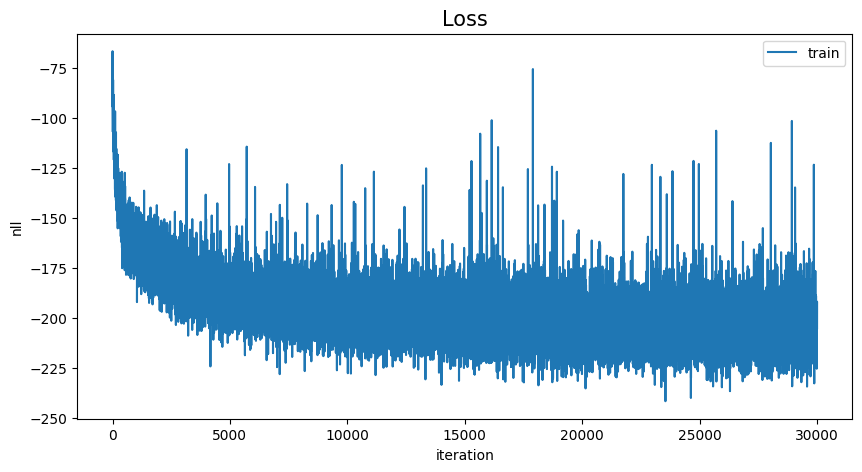

In [38]:
# view training
from datetime import datetime

loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
# plt.savefig(data_dir+"hf_informer4roqeto_loss_curve_"+str(datetime.now()).replace(":",".")+".png")
plt.show()

In [49]:
from huggingface_hub import notebook_login
notebook_login()

In [50]:
model.push_to_hub("shaddie/rocketpill_thrustcurve_informer_model",
                  use_auth_token=True,
                  commit_message="training-time-series-thrust-curve",
                  private=False)

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:907: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shaddie/rocketpill_thrustcurve_informer_model/commit/d366946a74301a98d27f2d83b91ad3c680f47525', commit_message='training-time-series-thrust-curve', commit_description='', oid='d366946a74301a98d27f2d83b91ad3c680f47525', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shaddie/rocketpill_thrustcurve_informer_model', endpoint='https://huggingface.co', repo_type='model', repo_id='shaddie/rocketpill_thrustcurve_informer_model'), pr_revision=None, pr_num=None)

In [41]:
# model

In [42]:
model.eval()

forecasts_ = []

test_progress_bar = tqdm(test_dataloader, desc=f"Epoch ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
for idx, batch in enumerate(test_progress_bar):
  for k, v in batch.items():
    print(k, v.shape, v.type())
  # print(f'past_observed_mask {batch["past_observed_mask"].to(device).repeat(1,1, 3).shape}')
  # print(f'future_time_features {batch["future_time_features"].to(device).shape}')
  outputs = model.generate(
    static_categorical_features=batch["static_categorical_features"].to(device)
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"].to(device)
    if config.num_static_real_features > 0
    else None,
    past_time_features=batch["past_time_features"].to(device),
    past_values=batch["past_values"].to(device),
    future_time_features=batch["future_time_features"].to(device),
    past_observed_mask=batch["past_observed_mask"].to(device),
)
forecasts_.append(outputs.sequences.cpu().numpy())

Epoch : 1it [00:00,  5.68it/s]

past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


In [43]:
forecasts_[0].shape

(1, 100, 8, 27)

In [44]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 8, 27)


In [45]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [46]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 3.6880505640384174


In [47]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 1.999999748730357


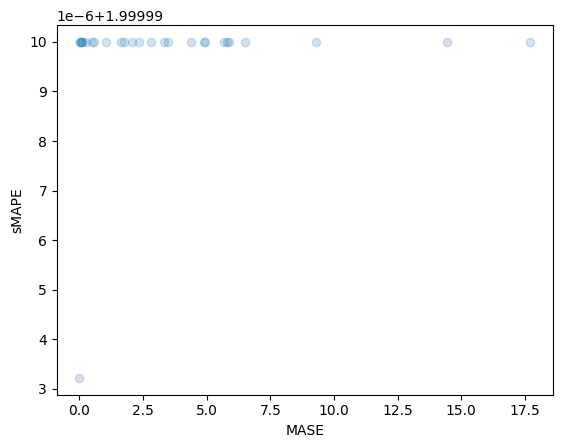

In [48]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()